In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

import mysql.connector

import gcGroupbyExtension

from config import Cfg as cfg

%matplotlib inline

## Race results

In [2]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [3]:
len(df_results.athlete.unique())

643055

## Races info

In [4]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [5]:
# -----------
# -- RACES --
# -----------


# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races['race'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019
df_results = df_results.loc[df_results['year'] < 2019]

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]


### what do we have left to work with?

In [6]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1654265
  Number of athletes: 579934
-- Races dataset --
  Number of active races: 159


## Race count per athlete

In [ ]:
# the SQL way
# --------------

# query = '''SELECT *
# FROM (
#          SELECT athlete, count(*) as count_races
#          FROM results
#          GROUP BY athlete
#      ) as t1
# ORDER BY count_races DESC'''

# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)
# athletes_race_count = pd.read_sql(query, con=cnx)
# cnx.close()

In [7]:
athletes_df = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

athletes_df.sort_values(by="n_races", ascending=False).head(10)

,athlete,n_races
525141,Taiwan Triathlete,686
132025,David Smith,179
129312,David Jones,166
389447,Michael Smith,164
267967,John Wragg,138
492408,Scott Smith,134
69405,Brian Smith,129
384019,Michael Brown,124
32305,Andrew Smith,115
129754,David Lee,114


The `Taiwan Thriathlete` is what the iRonMan website entered for every Taiwainese athlete ... and then there are probably several David Smith, Michael Smith, etc ... need to find a solution to isolated each one. Maybe using age group?

#### Let's get rid of anyone that has more than 100 races in results df. We cannot really trust those data

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,bib,country,date,fulldata,score,swim_score,run_score,bike_score,gender,n_races
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,167,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,16
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,1779,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,16
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,133,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,31
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,1780,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,24
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,1737,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,10


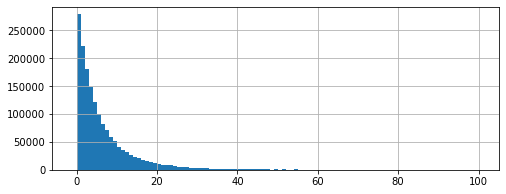

In [8]:
# we will use this filtered df from now on
df_results_filtered = df_results.merge(athletes_df, left_on="athlete", right_on="athlete", how="left")
df_results_filtered = df_results_filtered.loc[df_results_filtered['n_races']<=100]

# also remove athletes in athlete_df
athletes_df = athletes_df.loc[athletes_df['n_races']<=100]

df_results_filtered['n_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(8, 3))
df_results_filtered.head(5)

A majority of athletes have < 20 races

## We need to make a `profile` for each athlete. What features could we extract from the data we have?

## Years in sport

In [9]:
years_in_sport = (df_results_filtered
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('n_years_in_sport') 
)

athletes_df = athletes_df.merge(years_in_sport.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport
0,,17,4
1,,6,5
2,Avila,1,1
3,Fletcher,2,2
4,Grandjean,1,1


## Active years in sport

In [10]:
active_years = (
    df_results_filtered
        .groupby(['athlete', 'year'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_active_years_in_sport")
)

athletes_df = athletes_df.merge(active_years.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport
0,,17,4,5
1,,6,5,4
2,Avila,1,1,1
3,Fletcher,2,2,2
4,Grandjean,1,1,1


## Avg number of race per active year

In [11]:
athletes_df['avg_n_races_year'] = athletes_df['n_races']/athletes_df['n_active_years_in_sport']
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year
0,,17,4,5,3.4
1,,6,5,4,1.5
2,Avila,1,1,1,1.0
3,Fletcher,2,2,2,1.0
4,Grandjean,1,1,1,1.0


## Unique races

In [12]:
unique_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_unique_races")
)

athletes_df = athletes_df.merge(unique_races.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races
0,,17,4,5,3.4,6
1,,6,5,4,1.5,4
2,Avila,1,1,1,1.0,1
3,Fletcher,2,2,2,1.0,1
4,Grandjean,1,1,1,1.0,1


In [13]:
athletes_df['perc_unique_races'] = athletes_df['n_unique_races']/athletes_df['n_races']
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races
0,,17,4,5,3.4,6,0.352941
1,,6,5,4,1.5,4,0.666667
2,Avila,1,1,1,1.0,1,1.000000
3,Fletcher,2,2,2,1.0,1,0.500000
4,Grandjean,1,1,1,1.0,1,1.000000


# Internationality of the racer?

## Are the races raced in the same region/country?

In [14]:
# hash for races (region/country)
region_hash = {
    race: region for race,region in df_races[['race', 'region']].values
}
country_hash = {
    race: region for race,region in df_races[['race', 'country_code']].values
}


internationality = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
)

internationality['region'] = internationality.loc[:, 'race'].apply(lambda x: region_hash[x])
internationality['country'] = internationality.loc[:, 'race'].apply(lambda x: country_hash[x])

internationality_region = (
    internationality
        .groupby(['athlete', 'region'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_regions_raced")
)

internationality_country = (
    internationality
        .groupby(['athlete', 'country'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_countries_raced")
)



athletes_df = athletes_df.merge(internationality_region.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df = athletes_df.merge(internationality_country.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced
0,,17,4,5,3.4,6,0.352941,3.0,6
1,,6,5,4,1.5,4,0.666667,3.0,3
2,Avila,1,1,1,1.0,1,1.000000,1.0,1
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1


In [15]:
# What's the percentage of races done in different regions?
athletes_df["perc_races_in_diff_regions"] = athletes_df["n_regions_raced"]/athletes_df["n_unique_races"]
# What's the percentage of races done in different countries?
athletes_df["perc_races_in_diff_countries"] = athletes_df["n_countries_raced"]/athletes_df["n_unique_races"]

athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries
0,,17,4,5,3.4,6,0.352941,3.0,6,0.50,1.00
1,,6,5,4,1.5,4,0.666667,3.0,3,0.75,0.75
2,Avila,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1,1.00,1.00
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00


## Percentage of race done in the home country?

In [16]:
df_results_filtered['race_country'] = df_results_filtered.loc[:, 'race'].apply(lambda x: country_hash[x])
df_results_filtered['same_country'] = df_results_filtered['country'] == df_results_filtered['race_country']
df_results_filtered[['country', 'race_country', 'same_country']].head()

,country,race_country,same_country
0,USA,CHN,False
1,JPN,CHN,False
2,AUS,CHN,False
3,JPN,CHN,False
4,ESP,CHN,False


In [17]:
home_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])['same_country']
        .sum()
        .reset_index()
        .groupby('athlete')
        .sum()
        .reset_index()
        .rename(columns={'same_country': 'n_races_in_home_country'})
)

athletes_df = athletes_df.merge(home_races, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country
0,,17,4,5,3.4,6,0.352941,3.0,6,0.50,1.00,0.0
1,,6,5,4,1.5,4,0.666667,3.0,3,0.75,0.75,1.0
2,Avila,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1,1.00,1.00,2.0
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0


## Gender

In [18]:
df_results_filtered['gender'] = None
df_results_filtered.loc[df_results_filtered['division'].str.contains("M"), 'gender'] = "M"
df_results_filtered.loc[df_results_filtered['division'].str.contains("F"), 'gender'] = "F"
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,date,fulldata,score,swim_score,run_score,bike_score,gender,n_races,race_country,same_country
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,2016-11-13,0,98.4,100.0,86.1,100.0,M,16,CHN,False
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,2016-11-13,0,97.1,77.2,100.0,90.7,M,16,CHN,False
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,2016-11-13,0,99.9,100.0,100.0,99.7,M,31,CHN,False
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,2016-11-13,0,100.0,100.0,100.0,100.0,M,24,CHN,False
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,2016-11-13,0,99.6,100.0,98.3,99.0,M,10,CHN,False


In [19]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

athletes_df = athletes_df.merge(gender, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender
0,,17,4,5,3.4,6,0.352941,3.0,6,0.50,1.00,0.0,M
1,,6,5,4,1.5,4,0.666667,3.0,3,0.75,0.75,1.0,M
2,Avila,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1,1.00,1.00,2.0,F
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M


## Age Groups
This one is tricky, there could be several age groups is athlete long enough in the sport ... will have to average

In [20]:
df_results_filtered['ag'] = df_results_filtered.division.apply(
    lambda x: list(map(int, re.match("[M|F](\d+)-(\d+)", x).groups()))
    if re.match("[M|F](\d+)-(\d+)", x) 
    else [np.nan, np.nan]
)
df_results_filtered['ag_min'] = df_results_filtered.ag.apply(lambda x: x[0])
df_results_filtered['ag_max'] = df_results_filtered.ag.apply(lambda x: x[1])
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,swim_score,run_score,bike_score,gender,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,86.1,100.0,M,16,CHN,False,"[75, 79]",75.0,79.0
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,77.2,100.0,90.7,M,16,CHN,False,"[75, 79]",75.0,79.0
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,100.0,99.7,M,31,CHN,False,"[65, 69]",65.0,69.0
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,M,24,CHN,False,"[80, 84]",80.0,84.0
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,100.0,98.3,99.0,M,10,CHN,False,"[55, 59]",55.0,59.0


In [21]:
age_groups = (
    df_results_filtered
        .groupby(["athlete", "division"])
        .size()
        .reset_index()
        .groupby(['athlete'])
        .size()
        .reset_index()
        .rename(columns={0: "n_ag"})
)
age_groups.sort_values("n_ag", ascending=False).head()

,athlete,n_ag
0,,11
387712,Michael Miller,11
386416,Michael Jones,11
389616,Michael Stone,11
265811,John Martin,11


In [22]:
df_results_filtered.loc[df_results_filtered.athlete=="Michael Miller", ["ag_min", "ag_max"]].mean()

ag_min    43.789474
ag_max    47.859649
dtype: float64

In [23]:
age = (df_results_filtered
     .groupby(['athlete'])
     .mean()[['ag_min', 'ag_max']]
     .mean(axis=1)
     .reset_index()
     .rename(columns = {0: "age"})
)

athletes_df = athletes_df.merge(age, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age
0,,17,4,5,3.4,6,0.352941,3.0,6,0.50,1.00,0.0,M,46.411765
1,,6,5,4,1.5,4,0.666667,3.0,3,0.75,0.75,1.0,M,54.500000
2,Avila,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M,52.000000
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1,1.00,1.00,2.0,F,49.500000
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M,37.000000


## Rank

In [27]:
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,swim_score,run_score,bike_score,gender,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,86.1,100.0,M,16,CHN,False,"[75, 79]",75.0,79.0
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,77.2,100.0,90.7,M,16,CHN,False,"[75, 79]",75.0,79.0
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,100.0,99.7,M,31,CHN,False,"[65, 69]",65.0,69.0
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,M,24,CHN,False,"[80, 84]",80.0,84.0
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,100.0,98.3,99.0,M,10,CHN,False,"[55, 59]",55.0,59.0


In [39]:
rank = (df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['rankoverall']/g.rankoverall.max())
     .reset_index()
).merge(df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['athlete'])
     .reset_index()
)
rank.head()

,race,year,level_2,rankoverall,athlete
0,Arizona70.3,2015,206208,0.002727,Trevor Barron
1,Arizona70.3,2015,206213,0.060909,Daniel Murphy
2,Arizona70.3,2015,206217,0.102727,Andre Abreu
3,Arizona70.3,2015,206221,0.103636,Matthew Boufford
4,Arizona70.3,2015,206225,0.210909,Nick Falcon


In [52]:
selection = ["athlete", "swim_score", "bike_score", "run_score"]

activity_scores = (
    # keep only those who finished the race
    df_results_filtered.loc[(df_results_filtered.loc[:, selection][selection[1:]]>0).sum(axis=1) == 3, selection]
        .groupby('athlete')
        .mean()
        .reset_index()
)

athletes_df = athletes_df.merge(activity_scores, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age,swim_score,bike_score,run_score
0,,17,4,5,3.4,6,0.352941,3.0,6,0.50,1.00,0.0,M,46.411765,78.22,84.84,76.03
1,,6,5,4,1.5,4,0.666667,3.0,3,0.75,0.75,1.0,M,54.500000,80.48,94.72,92.90
2,Avila,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M,52.000000,89.60,90.60,97.80
3,Fletcher,2,2,2,1.0,1,0.500000,1.0,1,1.00,1.00,2.0,F,49.500000,81.50,87.70,79.20
4,Grandjean,1,1,1,1.0,1,1.000000,1.0,1,1.00,1.00,0.0,M,37.000000,92.40,97.80,99.70


# SAVE FILE

In [53]:
# save final
athletes_df.to_csv("./../data/clean/entrants_info_features.csv", index=False)

In [54]:
len(athletes_df)

579918